## Regresión por Procesos Gaussianos usando librerías de Tensorflow. Ejemplo Básico.
Bifurcación 01.lp.03.19

En este articulo se explora el proceso de regresión mediante Procesos Gaussianos utilizando las herramientas Tensorflow y tensorflow Probability de Google. Es una bifurcaciión del ejemplo presentado por Google Colab. 
Se generan observaciones ruidosas de funciones conocidas y se ajusta mediante un Modelo de Procesos Gaussianos (GP) los datos suministrados. Luego se realiza un muestreo del GP posterior y se grafican los valores de la función muestreada en su dominio.

**1**.- Importando Librerías


In [1]:

import numpy as np
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import matplotlib.pyplot as plt

In [12]:
# 
#Codigo para importar data desde archivo local en colab, mediante python  
#
# Importar libreria 
#  
import pandas as pd
# 
# Activar  ventana de importar data desde disco local 
# 
from google.colab import files
uploaded = files.upload()

Saving data2.csv to data2.csv


In [13]:
import io
# 
df2 = pd.read_csv(io.BytesIO(uploaded['data2.csv']))
# 
# Ahora el Dataset esta almacenado en un dataframe de Pandas
# 
# Imprimir y previsualizar el dataset
# 
print(df2)


    506
0   442
1   428
2   460
3   441
4   465
5   461
6   479
7   418
8   434
9   409
10  424
11  452
12  459
13  413


## Ejemplo. Regresion Exacta GP sobre Datos de Resistencia de Concreto. .
Se importan y leen una conjunto de datos de entrenamiento desde un dataset de ensayos de Resistencia a la Compresion de cilindros de Concreto, del prof  I-Cheng Yeh donados a UCI Machine Learning Repository   y  luego se genera un grupo de curvas de la distribución posterior del modelo. Usamos Adam para optimizar los hiperparámetros del kernel (minimizamos la verisimilitud log  negativa de los datos  a priori).  Trazamos la curva de entrenamiento, seguida de la función real y las muestras posteriores.
Source:
Original Owner and Donor
Prof. I-Cheng Yeh
Department of Information Management
Chung-Hua University,
Hsin Chu, Taiwan 30067, R.O.C. 

In [0]:
def reset_session():
  """Creación de una Sesión interactiva, nueva y global en modo Gráfico."""
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

reset_session()

In [0]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Observaciones del Conjunto de Datos de Resistencia del Concreto.

  Retorna:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + ruido
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [0]:
# Generar datos de entrenamiento con nivel de ruido conocido (se intentará recuperar 
# este valor de los datos).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [0]:
# Crear los parametros del modelo entrenable, el cual será optimizado luego.
# La restircción es que sea estrictament epositiva la función.
amplitude = (np.finfo(np.float64).tiny +
             tf.nn.softplus(tf.Variable(initial_value=1.,
                                        name='amplitude',
                                        dtype=np.float64)))
length_scale = (np.finfo(np.float64).tiny +
                tf.nn.softplus(tf.Variable(initial_value=1.,
                                           name='length_scale',
                                           dtype=np.float64)))

observation_noise_variance = (
    np.finfo(np.float64).tiny +
    tf.nn.softplus(tf.Variable(initial_value=1e-6,
                               name='observation_noise_variance',
                               dtype=np.float64)))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Create the covariance kernel, which will be shared between the prior (which we
# use for maximum likelihood training) and the posterior (which we use for
# posterior predictive sampling)
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

In [0]:
# Create the GP prior distribution, which we will use to train the model
# parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points_,
    observation_noise_variance=observation_noise_variance)

# This lets us compute the log likelihood of the observed data. Then we can
# maximize this quantity to find optimal model parameters.
log_likelihood = gp.log_prob(observations_)

In [0]:
# Define the optimization ops for maximizing likelihood (minimizing neg
# log-likelihood!)
optimizer = tf.train.AdamOptimizer(learning_rate=.01)
train_op = optimizer.minimize(-log_likelihood)

Instructions for updating:
Use tf.cast instead.


In [0]:
# Now we optimize the model parameters.
num_iters = 1000
# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
sess.run(tf.global_variables_initializer())
for i in range(num_iters):
  _, lls_[i] = sess.run([train_op, log_likelihood])

[amplitude_,
 length_scale_,
 observation_noise_variance_] = sess.run([
    amplitude,
    length_scale,
    observation_noise_variance])
print('Trained parameters:'.format(amplitude_))
print('amplitude: {}'.format(amplitude_))
print('length_scale: {}'.format(length_scale_))
print('observation_noise_variance: {}'.format(observation_noise_variance_))

Trained parameters:
amplitude: 0.33363860032922754
length_scale: 1.514777371568397
observation_noise_variance: 0.483903630731002


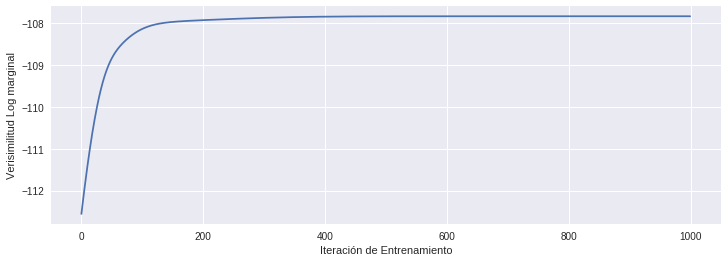

In [0]:
# Graficar la evolución de pérdidas
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Iteración de Entrenamiento")
plt.ylabel("Verisimilitud Log marginal")
plt.show()

In [0]:
# Habiendo entrenado el modelo, nos gustaría tomar muestras condicionadas por las observaciones posteirores
#  Nos gustaría que las muestras estuvieran en puntos 
#  distintos a los de la formación
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reformular a [200, 1] -- 1 es la dimensionalidad del espacio característico.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,  # Reusar el mismo kernel, con los mismos parámetros
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance,
    predictive_noise_variance=0.)

# Crear optimización para dibujar 50 muestras independientes, cada una de las cuales 
# es una extracción conjunta de la distribución posterior en predictive_index_points_. Since we have 200 input
# Dado que tenemos 200 ubicaciones de entrada como se definió anteriormente, 
# esta distribución posterior sobre los valores de función correspondientes es 
# una distribución gaussiana multivariante de 200 dimensiones.
num_samples = 50
samples = gprm.sample(num_samples)

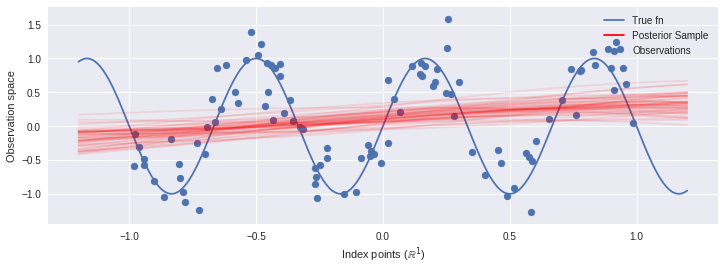

In [0]:
# Dibujar la muestra y visualizar.
samples_ = sess.run(samples)

# Graficar la función real, observaciones y muestra posterior.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples_[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()